<a href="https://colab.research.google.com/github/inuwamobarak/KOSMOS-2/blob/main/KOSMOS_2_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Python script demonstrates how to perform inference with Microsoft's multimodal large language model, KOSMOS-2, for multimodal grounding and referral.

You can also find the original Colab notebook from https://github.com/NielsRogge at https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/KOSMOS-2/Inference_with_KOSMOS_2_for_multimodal_grounding.ipynb

In this script, we'll walk through several steps to showcase KOSMOS-2's capabilities.

## Step 1: Set Up Environment
In this step, we install necessary dependencies like 🤗 Transformers, Accelerate, and Bitsandbytes. These libraries are crucial for efficient inference with KOSMOS-2.

In [2]:
!nvidia-smi
!pip install -q git+https://github.com/huggingface/transformers.git accelerate bitsandbytes

#验证SDK token
from modelscope.hub.api import HubApi
api = HubApi()
api.login('9a762920-0d70-4f94-xxxx-281037000000')

#模型下载
from modelscope import snapshot_download
model_dir = snapshot_download('blockai/kosmos-2')

Thu Sep  5 23:55:07 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 12.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10          On   | 00000000:00:07.0 Off |                    0 |
|  0%   27C    P8     9W / 150W |      0MiB / 22731MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------


## Step 2: Load KOSMOS-2 Model
Next, we load the KOSMOS-2 model and its processor.

In [1]:
from transformers import AutoProcessor, AutoModelForVision2Seq

processor = AutoProcessor.from_pretrained("/mnt/workspace/.cache/modelscope/hub/blockai/kosmos-2")
model = AutoModelForVision2Seq.from_pretrained("/mnt/workspace/.cache/modelscope/hub/blockai/kosmos-2", load_in_4bit=True, device_map={"": 0})

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
/usr/local/lib/python3.10/site-packages/_distutils_hack/__init__.py:55: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


## Step 3: Load Image and Prompt
In this step, we demonstrate image grounding. We load an image and provide a text prompt for the model to complete. We use the special `<grounding>` token, which is crucial for referencing objects in the image.

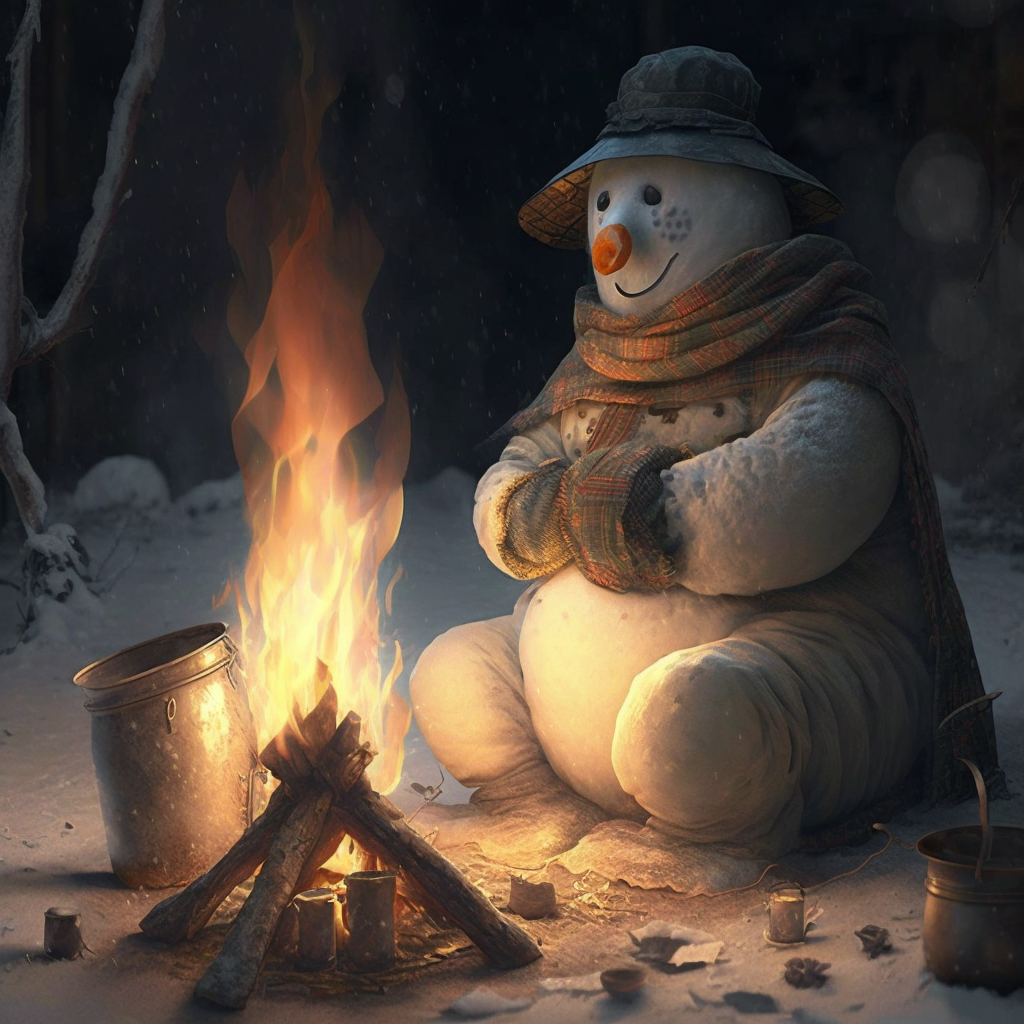

In [7]:
import requests
from PIL import Image

prompt = "<grounding>An image of"
# url = "https://www.modelscope.cn/models/blockai/kosmos-2/resolve/master/snowman.png"
# image = Image.open(requests.get(url, stream=True).raw)
image = Image.open("/mnt/workspace/.cache/modelscope/hub/blockai/kosmos-2/snowman.png")
image

## Step 4: Generate Completion
Next, we prepare the image and text prompt for the model using the processor. We then let the model autoregressively generate a completion. The generated completion provides information about the image and its content.

In [8]:
inputs = processor(text=prompt, images=image, return_tensors="pt").to("cuda:0")

# Autoregressively generate completion
generated_ids = model.generate(**inputs, max_new_tokens=128)
# Convert generated token IDs back to strings
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

/usr/local/lib/python3.10/site-packages/bitsandbytes/nn/modules.py:430: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(


## Step 5: Post-Processing
We look at the raw generated text, which may include some tokens related to image patches. This post-processing step ensures that we obtain meaningful results.

In [9]:
print(generated_text)

<image>. the, to and of as in I that' for is was- on’ it with The as at bet he have from by are " you his “ this said not has an ( but had we her they will my or were their): up about out who one all been she can more would It</image><grounding> An image of<phrase> a snowman</phrase><object><patch_index_0044><patch_index_0863></object> warming up by<phrase> a fire</phrase><object><patch_index_0006><patch_index_0879></object>


## Step 6: Further Processing
In this step, we focus on the generated text beyond the initial image-related tokens. We extract details such as object names, phrases, and location tokens. This extracted information is more meaningful and allows us to understand the model's response better.

In [10]:
# By default, the generated text is cleaned up and the entities are extracted.
processed_text, entities = processor.post_process_generation(generated_text)

print(processed_text)
print(entities)

An image of a snowman warming up by a fire
[('a snowman', (12, 21), [(0.390625, 0.046875, 0.984375, 0.828125)]), ('a fire', (36, 42), [(0.203125, 0.015625, 0.484375, 0.859375)])]


In [11]:
end_of_image_token = processor.eoi_token
caption = generated_text.split(end_of_image_token)[-1]
print(caption)

<grounding> An image of<phrase> a snowman</phrase><object><patch_index_0044><patch_index_0863></object> warming up by<phrase> a fire</phrase><object><patch_index_0006><patch_index_0879></object>


## Step 7: Plot Bounding Boxes
We demonstrate how to visualize the bounding boxes of objects identified in the image. This step allows us to understand where the model has located specific objects. We leverage the extracted information to annotate the image.

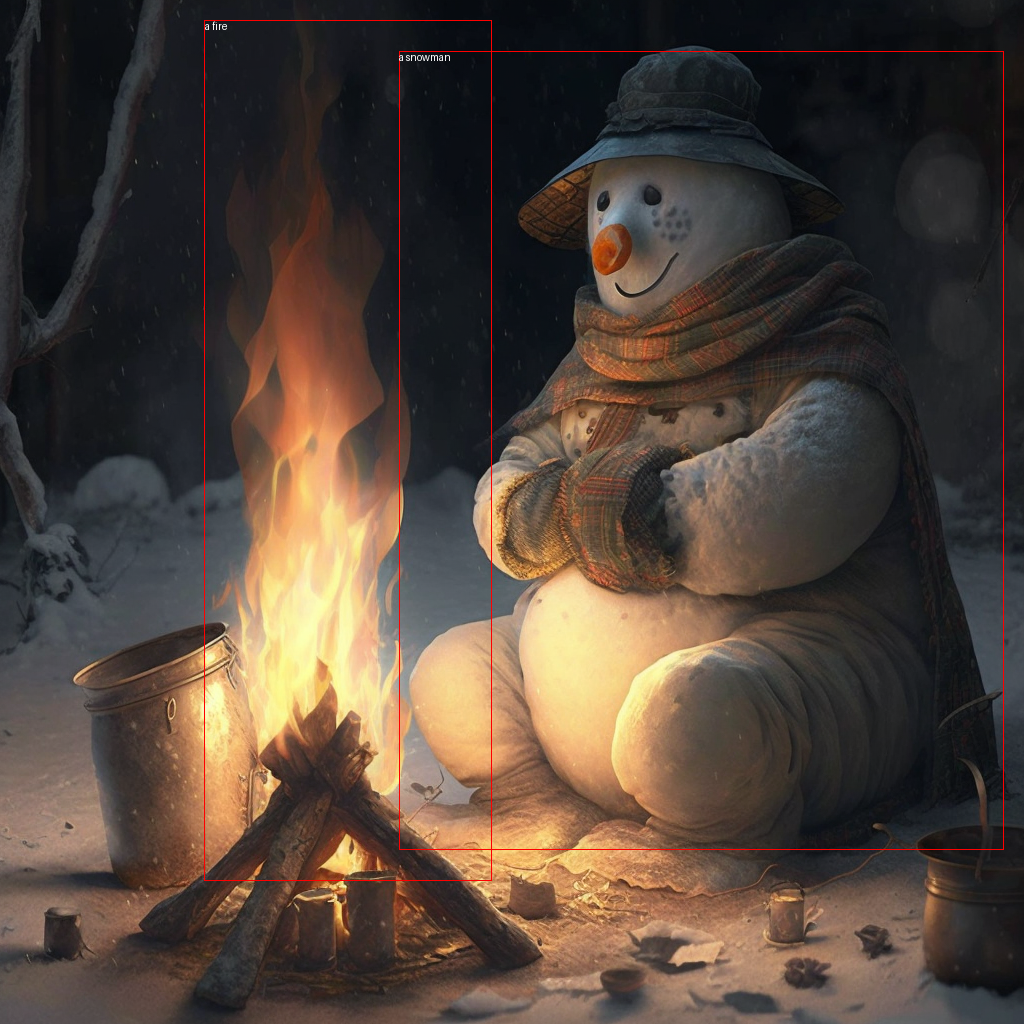

In [12]:
from PIL import ImageDraw

width, height = image.size
draw = ImageDraw.Draw(image)

for entity, _, box in entities:
    box = [round(i, 2) for i in box[0]]
    x1, y1, x2, y2 = tuple(box)
    x1, x2 = x1 * width, x2 * width
    y1, y2 = y1 * height, y2 * height
    draw.rectangle(xy=((x1, y1), (x2, y2)), outline="red")
    draw.text(xy=(x1, y1), text=entity)

image

## Step 8: Grounded Question Answering
KOSMOS-2 allows you to interact with specific objects in an image. In this step, we demonstrate how to prompt the model with a bounding box and a question related to a particular object. The model provides answers based on the context and information from the image.

--2024-09-08 22:45:13--  https://hf-mirror.com/ydshieh/kosmos-2-patch14-224/resolve/main/pikachu.png
正在解析主机 hf-mirror.com (hf-mirror.com)... 153.121.57.40, 160.16.199.204, 133.242.169.68
正在连接 hf-mirror.com (hf-mirror.com)|153.121.57.40|:443... 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


已连接。
已发出 HTTP 请求，正在等待回应... 302 Found
位置：https://cdn-lfs.hf-mirror.com/repos/81/ce/81ce6aba9ab2af6cd48e72ff6da0c5cb139db87d59754d2faaa6afdb0e37cde2/7bf04b0f0b3191819ade6bd8b6c7cb388636a010b1e812e05a746564f3c9d306?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27pikachu.png%3B+filename%3D%22pikachu.png%22%3B&response-content-type=image%2Fpng&Expires=1726065917&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyNjA2NTkxN319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy84MS9jZS84MWNlNmFiYTlhYjJhZjZjZDQ4ZTcyZmY2ZGEwYzVjYjEzOWRiODdkNTk3NTRkMmZhYWE2YWZkYjBlMzdjZGUyLzdiZjA0YjBmMGIzMTkxODE5YWRlNmJkOGI2YzdjYjM4ODYzNmEwMTBiMWU4MTJlMDVhNzQ2NTY0ZjNjOWQzMDY%7EcmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj0qJnJlc3BvbnNlLWNvbnRlbnQtdHlwZT0qIn1dfQ__&Signature=U586gjbW32rDvCbw3LLrCfRCAq3tNkrcqrj%7EH-onq0B5t00A-zNjFQHawBFCiwXLdSxZyXRNqqLYQDi94n6qgcKOzPDhclO93H7bN0kgSWHUuSnZ8WyEmDVdbTEtAcHXuU1DJn0zRxsuYhqW0daW-IZE%7EyoGT9h7gxj%7EGtoqnwJBK8Ae

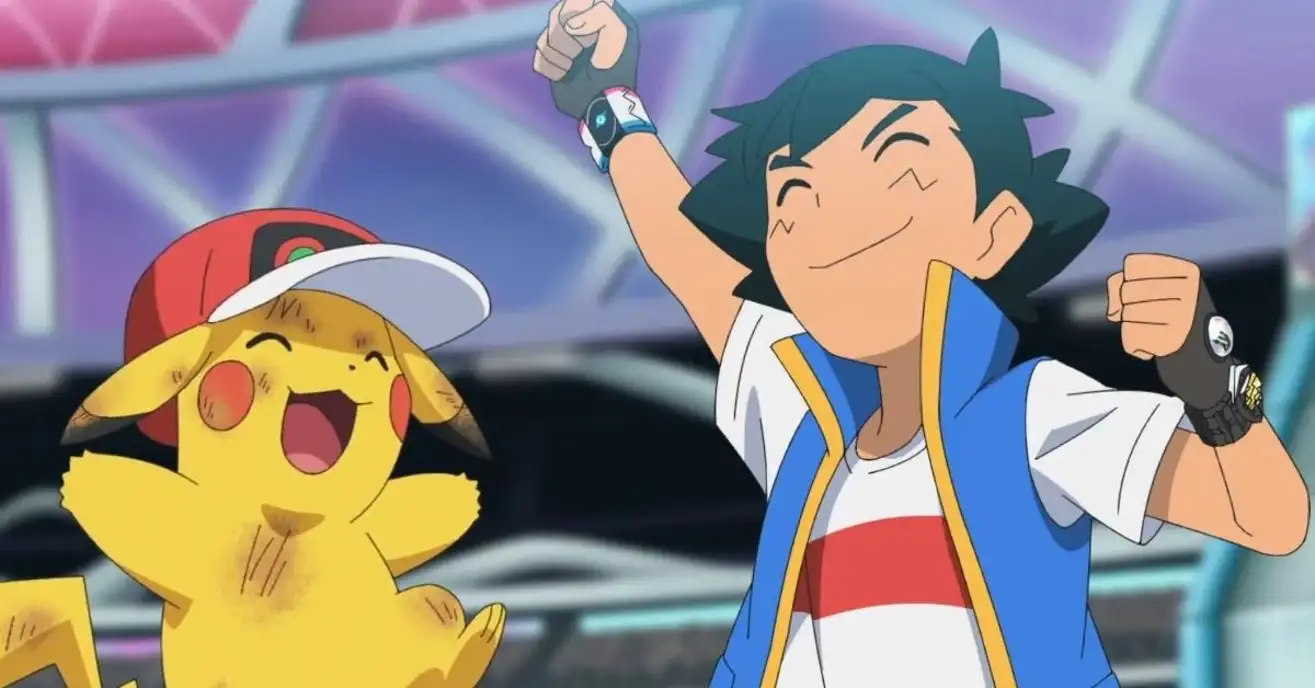

In [16]:
# url = "https://hf-mirror.com/ydshieh/kosmos-2-patch14-224/resolve/main/pikachu.png"
!wget "https://hf-mirror.com/ydshieh/kosmos-2-patch14-224/resolve/main/pikachu.png"
image = Image.open("/mnt/workspace/pikachu.png")
# image = Image.open(requests.get(url, stream=True).raw)
image

We can prepare a question and specify a bounding box for Pikachu. The use of special `<phrase>` tokens indicates the presence of a phrase in the question. This step showcases how to obtain specific information from an image using grounded question answering.


In [17]:
prompt = "<grounding> Question: What is<phrase> this character</phrase>? Answer:"

inputs = processor(text=prompt, images=image, bboxes=[(0.04182509505703422, 0.39244186046511625, 0.38783269961977185, 1.0)], return_tensors="pt").to("cuda:0")

## Step 9: Generate Grounded Answer
We allow the model to autoregressively complete the question, generating an answer based on the provided context. Grounded question answering enables us to obtain specific information about objects within an image.

In [18]:
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

# By default, the generated text is cleaned up, and the entities are extracted.
processed_text, entities = processor.post_process_generation(generated_text)

print(processed_text)
print(entities)

Question: What is this character? Answer: Pikachu in the anime.
[('this character', (18, 32), [(0.046875, 0.390625, 0.390625, 0.984375)])]
